In [94]:
import pandas as pd
import numpy as np
from collections import Counter
import random
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
import pickle
import surprise
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate,train_test_split,KFold
from surprise import SVD,SVDpp, NMF,SlopeOne,CoClustering
from surprise import accuracy
from collections import defaultdict

my_seed = 789
random.seed(my_seed)

In [95]:
interaction = pd.read_csv("src/data/kaggle_food_data/RAW_interactions.csv")
recipes = pd.read_pickle("src/data/kaggle_food_data/raw_recipes.pkl")

In [96]:
recipes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   name            231636 non-null  object
 1   id              231637 non-null  int64 
 2   minutes         231637 non-null  int64 
 3   contributor_id  231637 non-null  int64 
 4   submitted       231637 non-null  object
 5   tags            231637 non-null  object
 6   nutrition       231637 non-null  object
 7   n_steps         231637 non-null  int64 
 8   steps           231637 non-null  object
 9   description     226658 non-null  object
 10  ingredients     231637 non-null  object
 11  n_ingredients   231637 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 21.2+ MB


In [97]:
interaction.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [98]:
recipes.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"[60-minutes-or-less, time-to-make, course, mai...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"[make a choice and proceed with recipe, depend...",autumn is my favorite time of year to cook! th...,"[winter squash, mexican seasoning, mixed spice...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"[30-minutes-or-less, time-to-make, course, mai...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"[preheat oven to 425 degrees f, press dough in...",this recipe calls for the crust to be prebaked...,"[prepared pizza crust, sausage patty, eggs, mi...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"[time-to-make, course, preparation, main-dish,...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"[brown ground beef in large pot, add chopped o...",this modified version of 'mom's' chili was a h...,"[ground beef, yellow onions, diced tomatoes, t...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"[60-minutes-or-less, time-to-make, course, mai...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,[place potatoes in a large pot of lightly salt...,"this is a super easy, great tasting, make ahea...","[spreadable cheese with garlic and herbs, new ...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"[weeknight, time-to-make, course, main-ingredi...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,"[mix all ingredients& boil for 2 1 / 2 hours ,...",my dh's amish mother raised him on this recipe...,"[tomato juice, apple cider vinegar, sugar, sal...",8


In [99]:
def make_df_from_count(serie,name):
    counts = dict(Counter(serie))
    return pd.DataFrame.from_dict(counts,orient='index').reset_index().rename(columns={'index':name,0:f'{name}_count'})
recipe_df = make_df_from_count(interaction.recipe_id,'recipe_id')

In [100]:
print(len(recipe_df[recipe_df['recipe_id_count'] <= 1])/len(recipe_df))
print(len(recipe_df[recipe_df['recipe_id_count'] <= 10])/len(recipe_df))

0.39697025950085696
0.9189896260096617


around 40% of recipes have 1 or less reviews

around 92% of recipes have less than or equal to 10 reviews

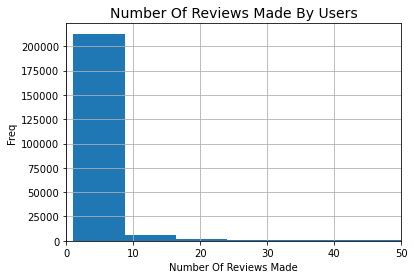

In [8]:
user_df = make_df_from_count(interaction.user_id,'user_id')
user_df['user_id_count'].hist(bins = 1000)
plt.title("number of reviews made by users".title(), fontsize = 14)
ax = plt.gca()
ax.set_xlim((0,50))
plt.xlabel("Number of reviews made".title())
plt.ylabel("Freq");

In [9]:
print(f"percentage of users with less than or equal to 10 reivews: {len(user_df[user_df.user_id_count <=10])/len(user_df)}")

percentage of users with less than or equal to 10 reivews: 0.9494813964779097


In [10]:
merged_df = interaction.merge(recipe_df,how="left", left_on="recipe_id",right_on = "recipe_id")

In [11]:
merged_df

,user_id,recipe_id,date,rating,review,recipe_id_count
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...,2
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall...",2
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...,1
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...,2
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin...",2
...,...,...,...,...,...,...
1132362,116593,72730,2003-12-09,0,Another approach is to start making sauce with...,1
1132363,583662,386618,2009-09-29,5,These were so delicious! My husband and I tru...,1
1132364,157126,78003,2008-06-23,5,WOW! Sometimes I don't take the time to rate ...,4
1132365,53932,78003,2009-01-11,4,Very good! I used regular port as well. The ...,4


In [50]:
interaction.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [118]:
# Surprise
# scale rating to 0 to 1
df_touse = interaction.copy()
df_touse["rating"] = df_touse["rating"].apply(lambda x: x/5)

# create reader for the dataset
scaled_reader = Reader(rating_scale = (0,1))
scaled_surprise_data = Dataset.load_from_df(df_touse["user_id recipe_id rating".split(" ")], scaled_reader)

reader = Reader(rating_scale= (0,5))
surprise_data = Dataset.load_from_df(interaction[["user_id","recipe_id","rating"]], reader)

# split into train test
#scaled_train, scaled_test = train_test_split(scaled_surprise_data, test_size = .25, random_state = 789)
#train, test = train_test_split(surprise_data, test_size = .25, random_state = 789)

In [129]:
param_grid = {"n_factors":[100,150,200],
             "n_epochs":[20,25,30],
             "lr_all":[0.005,0.0001,0.0005],
             "reg_all":[0.01,0.015,0.02,0.025],
             "random_state":[789],
             "verbose":[True]}
gs = surprise.model_selection.GridSearchCV(SVD,
                                           param_grid = param_grid, 
                                           measures = ["mae","rmse"],
                                           return_train_measures = True,
                                           n_jobs= 3,cv=3,
                                          joblib_verbose = 4)

In [130]:
gs.fit(surprise_data)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed:  7.4min
[Parallel(n_jobs=3)]: Done  92 tasks      | elapsed: 36.4min
[Parallel(n_jobs=3)]: Done 215 tasks      | elapsed: 95.7min
[Parallel(n_jobs=3)]: Done 324 out of 324 | elapsed: 159.3min finished


In [145]:
results_df = pd.DataFrame(gs.cv_results)

In [149]:
results_df.sort_values("mean_test_mae")

,split0_test_mae,split0_train_mae,split1_test_mae,split1_train_mae,split2_test_mae,split2_train_mae,mean_test_mae,std_test_mae,mean_train_mae,std_train_mae,...,std_fit_time,mean_test_time,std_test_time,params,param_n_factors,param_n_epochs,param_lr_all,param_reg_all,param_random_state,param_verbose
3,0.740966,0.506554,0.740879,0.507769,0.738849,0.507849,0.740231,0.000978,0.507391,0.000592,...,0.318277,3.001678,0.041082,"{'n_factors': 100, 'n_epochs': 20, 'lr_all': 0...",100,20,0.0050,0.025,789,True
2,0.741349,0.499156,0.741277,0.500439,0.739250,0.500482,0.740625,0.000973,0.500025,0.000615,...,0.264047,2.920774,0.037507,"{'n_factors': 100, 'n_epochs': 20, 'lr_all': 0...",100,20,0.0050,0.020,789,True
15,0.741354,0.447256,0.741425,0.448383,0.739289,0.448169,0.740689,0.000990,0.447936,0.000488,...,0.997426,3.149929,0.267081,"{'n_factors': 100, 'n_epochs': 25, 'lr_all': 0...",100,25,0.0050,0.025,789,True
1,0.741963,0.490991,0.741900,0.492354,0.739871,0.492355,0.741245,0.000972,0.491900,0.000643,...,0.332369,3.021516,0.053134,"{'n_factors': 100, 'n_epochs': 20, 'lr_all': 0...",100,20,0.0050,0.015,789,True
39,0.742469,0.456157,0.741824,0.457001,0.739742,0.457043,0.741345,0.001164,0.456734,0.000408,...,1.202768,2.792296,0.127482,"{'n_factors': 150, 'n_epochs': 20, 'lr_all': 0...",150,20,0.0050,0.025,789,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,0.794368,0.784340,0.793541,0.785398,0.791796,0.786836,0.793235,0.001072,0.785525,0.001023,...,0.995253,2.945010,0.032458,"{'n_factors': 150, 'n_epochs': 20, 'lr_all': 0...",150,20,0.0001,0.025,789,True
76,0.794240,0.782707,0.793764,0.783644,0.792024,0.785345,0.793343,0.000953,0.783899,0.001092,...,0.323355,2.743851,0.107646,"{'n_factors': 200, 'n_epochs': 20, 'lr_all': 0...",200,20,0.0001,0.010,789,True
77,0.794357,0.782825,0.793879,0.783764,0.792140,0.785464,0.793459,0.000953,0.784017,0.001092,...,0.168507,2.748157,0.051894,"{'n_factors': 200, 'n_epochs': 20, 'lr_all': 0...",200,20,0.0001,0.015,789,True
78,0.794476,0.782945,0.793996,0.783885,0.792257,0.785585,0.793576,0.000953,0.784138,0.001092,...,0.579962,2.798492,0.153899,"{'n_factors': 200, 'n_epochs': 20, 'lr_all': 0...",200,20,0.0001,0.020,789,True


In [141]:
# best params with n_factors: 100, n_epochs: 20, lr_all: 0.005, reg_all: 0.025, random_state: 789
gs.best_params

{'mae': {'n_factors': 100,
  'n_epochs': 20,
  'lr_all': 0.005,
  'reg_all': 0.025,
  'random_state': 789,
  'verbose': True},
 'rmse': {'n_factors': 100,
  'n_epochs': 20,
  'lr_all': 0.005,
  'reg_all': 0.025,
  'random_state': 789,
  'verbose': True}}

In [167]:
alg_touse = SVD(gs.best_params["mae"])
full_trainset = surprise_data.build_full_trainset()
alg = SVD(n_factors=100, n_epochs=20, lr_all= 0.005, reg_all= 0.025, random_state= 789,verbose=True)

In [168]:
alg.fit(full_trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19


In [36]:
cross_validate(alg3,surprise_data, measures = ["RMSE","MAE", "MSE","FCP"], cv=5, verbose = True)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE, MSE, FCP of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2126  1.2079  1.2190  1.2161  1.2093  1.2130  0.0041  
MAE (testset)     0.7369  0.7356  0.7397  0.7387  0.7357  0.7373  0.0016  
MSE (testset)     1.4704  1.4590  1.4861  1.4789  1.4624  1.4714  0.0101  
FCP (testset)     0.5586  0.5593  0.5557  0.5679  0.5579  0.5599  0.0042  
Fit time          5.75    5.89    5.89    5.88    5.93    5.87    0.06    
Test time         2.21    2.21    2.17    1.09    1.09    1.75    0.54    


{'test_rmse': array([1.21261046, 1.20790606, 1.21903848, 1.21611338, 1.20929583]),
 'test_mae': array([0.73692754, 0.73556253, 0.73969687, 0.73871234, 0.73571318]),
 'test_mse': array([1.47042413, 1.45903704, 1.48605481, 1.47893175, 1.46239641]),
 'test_fcp': array([0.55863365, 0.559253  , 0.555666  , 0.56792631, 0.55794164]),
 'fit_time': (5.748038291931152,
  5.889524221420288,
  5.88830828666687,
  5.879220008850098,
  5.927901029586792),
 'test_time': (2.2128350734710693,
  2.2068493366241455,
  2.174938917160034,
  1.0918805599212646,
  1.085900068283081)}

In [212]:
alg.predict(214,123123).est/5

0.8822032079705607

In [37]:
cross_validate(alg2,surprise_data, measures = ["RMSE","MAE", "MSE","FCP"], cv=5, verbose = True) #cocluster

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing

{'test_rmse': array([1.3375221 , 1.33025163, 1.33421013, 1.34580616, 1.33101686]),
 'test_mae': array([0.75085095, 0.74309179, 0.74817085, 0.75533755, 0.74574301]),
 'test_mse': array([1.78896538, 1.76956941, 1.78011668, 1.81119422, 1.77160588]),
 'test_fcp': array([0.56616064, 0.56499907, 0.56823175, 0.57141384, 0.57807488]),
 'fit_time': (92.32270288467407,
  91.03620839118958,
  94.75179290771484,
  92.24778485298157,
  93.75015997886658),
 'test_time': (2.565333366394043,
  1.2346060276031494,
  1.2256550788879395,
  1.2245159149169922,
  1.2471482753753662)}

In [38]:
cross_validate(alg1,surprise_data, measures = ["RMSE","MAE", "MSE","FCP"], cv=5, verbose = True) # svd

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing

{'test_rmse': array([1.22805336, 1.21943685, 1.21610977, 1.22514132, 1.22139794]),
 'test_mae': array([0.74263939, 0.73850118, 0.73680093, 0.74253574, 0.74187275]),
 'test_mse': array([1.50811505, 1.48702623, 1.47892296, 1.50097126, 1.49181293]),
 'test_fcp': array([0.52845425, 0.52846502, 0.5311042 , 0.52534624, 0.52600477]),
 'fit_time': (74.54801774024963,
  74.87079310417175,
  73.96500444412231,
  74.01024007797241,
  75.50473523139954),
 'test_time': (1.583761215209961,
  1.567356824874878,
  1.5228426456451416,
  1.6944983005523682,
  2.6653008460998535)}

In [46]:
print(alg1.predict(245,1245))
print(alg2.predict(245,1245))#, verbose=True))
print(alg3.predict(245,1245))#, verbose=True))


user: 245        item: 1245       r_ui = None   est = 4.41   {'was_impossible': False}
user: 245        item: 1245       r_ui = None   est = 4.41   {'was_impossible': False}
user: 245        item: 1245       r_ui = None   est = 4.41   {'was_impossible': False}


In [143]:
alg1.top_recommendations()

In [51]:
recipes.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"[60-minutes-or-less, time-to-make, course, mai...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"[make a choice and proceed with recipe, depend...",autumn is my favorite time of year to cook! th...,"[winter squash, mexican seasoning, mixed spice...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"[30-minutes-or-less, time-to-make, course, mai...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"[preheat oven to 425 degrees f, press dough in...",this recipe calls for the crust to be prebaked...,"[prepared pizza crust, sausage patty, eggs, mi...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"[time-to-make, course, preparation, main-dish,...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"[brown ground beef in large pot, add chopped o...",this modified version of 'mom's' chili was a h...,"[ground beef, yellow onions, diced tomatoes, t...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"[60-minutes-or-less, time-to-make, course, mai...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,[place potatoes in a large pot of lightly salt...,"this is a super easy, great tasting, make ahea...","[spreadable cheese with garlic and herbs, new ...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"[weeknight, time-to-make, course, main-ingredi...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,"[mix all ingredients& boil for 2 1 / 2 hours ,...",my dh's amish mother raised him on this recipe...,"[tomato juice, apple cider vinegar, sugar, sal...",8


(array([ 60847.,      0.,  12818.,      0.,  14123.,      0.,  40855.,
             0., 187360., 816364.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

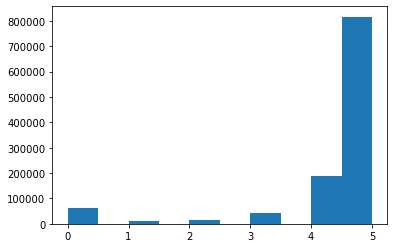

In [57]:
plt.hist(interaction["rating"]);

In [198]:
inter_copy = interaction.copy()
inter_copy.head()
temp_data = {"user_id":"special_user","recipe_id": 12374, "date":None, "rating":3, "review":None}
temp_user_data_df = pd.DataFrame(temp_data, index = [0])
inter_copy.append(temp_user_data_df)

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."
...,...,...,...,...,...
1132363,583662,386618,2009-09-29,5,These were so delicious! My husband and I tru...
1132364,157126,78003,2008-06-23,5,WOW! Sometimes I don't take the time to rate ...
1132365,53932,78003,2009-01-11,4,Very good! I used regular port as well. The ...
1132366,2001868099,78003,2017-12-18,5,I am so glad I googled and found this here. Th...
